In [1]:
# importing dependencies
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
# import preprocessor as p

### For keyword-based model development, I would try following steps, and based on each step's results, I would try  to improve model accuracy

Step 1: Keyword matching First, keyword matching will be performed. If the hate keyword matches the sentence, it will return hate samples otherwise normal.

Step 2: contextual keyword embedding matching with contextual post embedding


<i><strong>Dataset will be divided into training and testing; we will use the training part dataset to build the keyword list so that model does not overfit.<strong><i>

In [2]:
#read dataset jason format and convert into pandas dataframe
df = pd.read_json('data/dataset.json')


In [3]:
### step 1 key word matching
data=df.T.reset_index().drop(['index'], axis=1)
data['annotators'] = data['annotators'].apply((lambda x: x[0]['label']))
data['annotators'] = data['annotators'] .apply((lambda x: re.sub('normal','0',x)))
data['annotators'] = data['annotators'] .apply((lambda x: re.sub('hatespeech','1',x)))
data['annotators'] = data['annotators'] .apply((lambda x: re.sub('offensive','1',x)))
data['annotators'] =pd.to_numeric(data['annotators'])
data



,post_id,annotators,rationales,post_tokens
0,1179055004553900032_twitter,0,[],"[i, dont, think, im, getting, my, baby, them, ..."
1,1179063826874032128_twitter,0,[],"[we, cannot, continue, calling, ourselves, fem..."
2,1178793830532956161_twitter,0,[],"[nawt, yall, niggers, ignoring, me]"
3,1179088797964763136_twitter,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<user>, i, am, bit, confused, coz, chinese, p..."
4,1179085312976445440_twitter,1,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[this, bitch, in, whataburger, eating, a, burg..."
...,...,...,...,...
20143,9989999_gab,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,...","[if, ur, still, on, twitter, tell, carlton, i,..."
20144,9990225_gab,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,...","[when, i, first, got, on, here, and, said, i, ..."
20145,9991681_gab,1,[],"[was, macht, der, moslem, wenn, der, zion, geg..."
20146,9992513_gab,1,"[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,...","[it, is, awful, look, at, world, demographics,..."


In [31]:
nltk.download('stopwords')  # Download the stopwords list
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mjahan18\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
keywords = pd.read_csv('keywords/hatespeech_keywords.csv')
keywords

,keywords
0,beaners
1,filthy
2,kike
3,beaner
4,nigger
5,kikes
6,mudslime
7,shill
8,spic
9,sand


#### STEP 1 keyword mathcing modle

In [6]:
import re

# Function that takes a text input and returns a binary label for hate speech (1 if the input contains any of the hate keywords, 0 otherwise)
def classify_text(text):
    text=" ".join(text)
    for keyword in keywords['keywords']:
        if re.search(keyword, text, re.IGNORECASE):
            return 1
    return 0

# Example usage:
predictions=[]
for sen in data['post_tokens']:
    predictions.append(classify_text(sen))
    
# accuracy calculation     
accuracy = metrics.accuracy_score(np.array(predictions),np.array(data['annotators']))
print('Accuracy of simple hate key word matching: ', accuracy)

Accuracy of simple hate key word matching:  0.6036827476672623


In [7]:
# accuracy calculation     
accuracy = metrics.classification_report(np.array(predictions),np.array(data['annotators']))
print('Accuracy of simple hate key word matching: ', accuracy)

Accuracy of simple hate key word matching:                precision    recall  f1-score   support

           0       0.64      0.51      0.57     10220
           1       0.58      0.70      0.63      9928

    accuracy                           0.60     20148
   macro avg       0.61      0.61      0.60     20148
weighted avg       0.61      0.60      0.60     20148



### Step -2

Here first string matching model  provides 60%. This accuray is low and there of coule of thing should be focused, Firstly the keywords that has been provided is not adequte and some are not even hate speech keyword which can be used as not hate keyord (e.g, muslimes, jews). In this case follwowing update can be done, for example, making a hate topic model with multiple important key words. Also adding more hateful keywords in the keyword list would be helpful.

#### Following updates are performaing in second steps
1. Adding more hate keywwords and hate phrases in the keylist
3. Calculate contectual synonyms and consine similarty with selected hate keywords or phases

In [8]:
# Load bert tokenizer and model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")


In [29]:
# Collect hate words or phrases from dataset. Coolected only thos words which all three annotators consider as hate
# to do that i have mapped post tokens with annotators rationalies. 
hate_words=[]
for i in range(20000):
    if data['annotators'][i]==1:
        try:
                    # Example input data
            lists = data['rationales'][i]
            words = data['post_tokens'][i]

            # Find indices of 1s in the sublists and add corresponding words to a list
            matches = []
            for sublist in lists:
                sublist_matches = [words[i] for i, x in enumerate(sublist) if x == 1]
                matches.append(sublist_matches)

            # Find common words in all sublists
            common_words = []
            for i in range(len(matches[0])):
                word = matches[0][i]
                if all(word in sublist for sublist in matches[1:]):
                    common_words.append(word)
                    

            if len(common_words) >=1:
                # Print the common words
#                 filtered_words = [word for word in common_words if word.lower() not in stop_words]
                # Join the filtered words back into a sentence
                filtered_sentence = ' '.join(common_words)
                
                hate_words.append( filtered_sentence)

        except:
            pass

In [30]:
#remove duplciate words form list
hate_words = list(set(hate_words))
hate_words = list(filter(lambda x: x != "", hate_words))
len(hate_words)

4680

In [31]:
### create contectual BERT embeddings of a words
keyword_embeddings = []
for k in hate_words:
    encoded_input = tokenizer(k, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
        embeddings = output.last_hidden_state.mean(dim=1)
        keyword_embeddings.append(embeddings)

In [60]:
def cosine_similarity_roberta(embeddings1, embeddings2):
    # Calculate cosine similarity between the two embeddings
    similarity = torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim=1)
    return similarity

def keyword_model(post, threshold):
    # Get embeddings for the post
    post=" ".join(post)
    encoded_input = tokenizer(post, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
        post_embeddings = output.last_hidden_state.mean(dim=1)

    # Calculate cosine similarity between the post and all keywords
    total_similarity = 0
    min_length = min(len(keyword_embeddings), len(keywords['keywords']))
    for i in range(min_length):
        word_count = len(keywords['keywords'][i].split())
        similarities = torch.nn.functional.cosine_similarity(post_embeddings, keyword_embeddings[i], dim=1)
        total_similarity += similarities.item()

    # Check if the total similarity is high enough
    if total_similarity / min_length >= threshold:
        return 1
    return 0



In [61]:
# predictions 
predictions = []
for sen in data['post_tokens'][:2000]:
    predictions.append(keyword_model(sen, 0.20000000000000004))


In [62]:
# accuracy calculation     
accuracy = metrics.classification_report(np.array(predictions),np.array(data['annotators'][:2000]))
print('Accuracy of simple hate key word matching: ', accuracy)

Accuracy of simple hate key word matching:                precision    recall  f1-score   support

           0       0.03      0.76      0.06        37
           1       0.99      0.52      0.68      1963

    accuracy                           0.53      2000
   macro avg       0.51      0.64      0.37      2000
weighted avg       0.97      0.53      0.67      2000



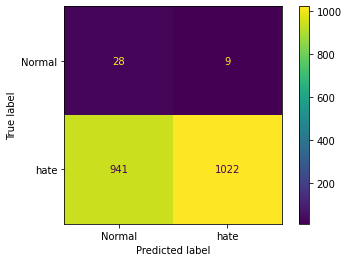

In [63]:
confusion_matrix = metrics.confusion_matrix(np.array(predictions),np.array(data['annotators'][:2000]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Normal', 'hate'])
cm_display.plot()
plt.show()


In [ ]:
##finding best thresolds

In [50]:
from sklearn.metrics import f1_score

# The range of thresholds to test
thresholds = np.arange(0.1, 0.5, 0.05)

best_threshold = None
best_f1 = 0

for threshold in thresholds:
    # Make predictions on the validation set
    predictions = []
    for sen in data['post_tokens'][:2000]:
        predictions.append(keyword_model(sen, threshold))  # Add threshold as argument here

    # Calculate the F1 score
    f1 = f1_score(data['annotators'][:2000], predictions)

    # Update the best threshold if this F1 score is better
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold}, Best F1 score: {best_f1}')

Best threshold: 0.20000000000000004, Best F1 score: 0.6826987307949232
